# Introduction
 This *.ipynb* file was generated by VSCode from *script.py*. See VSCode documentation for more infos.


 The aim of this project is to identify common English words in the human proteome.
 For this I have an English dictionnary with 3,000 words and a *human-proteom.fasta* file containing the human proteome.

 First, let's load some modules!

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO # Allow me to read human-proteome.fasta file
from collections import Counter # Count the number of each character

sns.set_style('darkgrid')

pd.set_option('display.max_rows', 1000)


# Loading data
 Now I will load all the I need for this project: the dictionnary and the proteome files.

In [2]:
dico_file = open("english-words.txt", "r") # Open the dico file

dico = dico_file.readlines() # Convert it to list object
dico = [s.replace("\n", "") for s in dico] # Remove \n from each string.

length_word = [len(l) for l in dico]

dico = pd.DataFrame(list(zip(dico, length_word)), columns=["word", "n_char"])
print("Found %i words" % len(dico))

sequences = [] # Create empty list for storing all sequences
name = []
for sequence in SeqIO.parse("human-proteome.fasta", "fasta"):
    sequences.append(str(sequence.seq)) # Convert _seq object to string
    name.append(sequence.name)


sequences = pd.DataFrame(list(zip(name, sequences)), columns=["name", "seq"])
sequences["seq_length"] = sequences["seq"].str.len()

print("Found %i sequences" % len(sequences))


Found 3000 words
Found 20373 sequences


 I have got 3,000 words, excellent! And I have got more than 20,000 sequences, awesome!

# Exploratory data analysis
 Now I will explore the two datasets.

In [3]:
sequences.head()
dico.head()


,word,n_char
0,a,1
1,abandon,7
2,ability,7
3,able,4
4,abortion,8


 Ok so all the proteome code seem to be in upper case. Check that.

In [4]:
all(sequences["seq"].str.isupper())


True

 All sequences character are in upper case.
 So let's modify `dico["word"]` to upper case.

In [5]:
dico["word"] = dico["word"].str.upper()


 Now I will look at some summary statisics
 from the dico and the sequences dataframes.

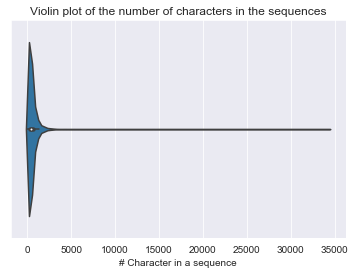

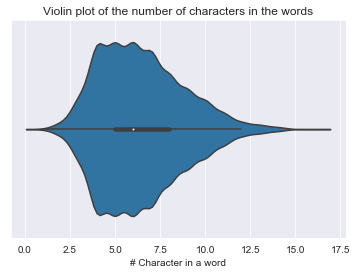

In [6]:
dico["n_char"].describe()
sequences["seq_length"].describe()


f1 = sns.violinplot(sequences["seq_length"])
f1.set(title="Violin plot of the number of characters in the sequences",
       xlabel="# Character in a sequence")
plt.show()

f2 = sns.violinplot(dico["n_char"])
f2.set(title="Violin plot of the number of characters in the words",
       xlabel="# Character in a word")
plt.show()


 So there is a very small sequence and a very large one. But the median is around 415 character length.
 Theses observations are confirmed by the violin plot, showing one BIG sequence and
 most of the sequences density around few hundreds characters.

 Moreover for the dico dataframe,
 I can see that there is some word with one character, maybe I choose remove it?
 Most of the words are less thant 10 characters longs.

 Now, let's see the letter distribution in words and sequences.

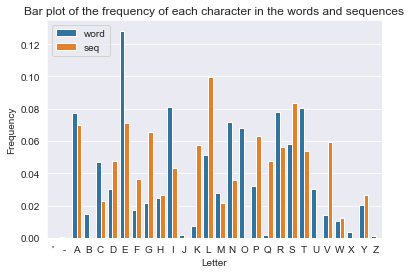

In [7]:
letters_seq = (
                pd.DataFrame.from_dict(Counter(''.join(sequences["seq"].tolist())), # Count occurences of each characters in the dico["word"]
                 orient="index") # And convert the count to pd.DataFrame
                .reset_index() # Because counter return a dictionary, letters are stored in the index, so get them out the index
                .rename(columns={'index' : 'letter', 0 : 'count'}) # Cleaning a bit the name of the columns
                .sort_values(by='letter') # Sort value by alphabetical order
                .reset_index(drop=True) # Index is now mess up, so now I reset it
                .assign(percap=lambda df: df["count"]/df["count"].sum()) # Percentage of this letters on all sequences
                .assign(type="seq")
                )
                
letters_word = (
                pd.DataFrame.from_dict(Counter(''.join(dico["word"].tolist())),
                orient='index')
                .reset_index()
                .rename(columns={'index' : 'letter', 0 : 'count'})
                .sort_values(by='letter')
                .reset_index(drop=True)
                .assign(percap=lambda df: df["count"]/df["count"].sum())
                .assign(type="word")
                )

letters = (pd.merge(letters_seq, letters_word, how='outer', 
                   on=["letter", "count", "percap", "type"])
           .sort_values(by="letter")
           )


f3 = sns.barplot(x='letter', y='percap', hue='type', data=letters)
f3.set(ylabel="Frequency",
       xlabel="Letter",
       title="Bar plot of the frequency of each character in the words and sequences")
f3.legend(loc='upper left')
plt.show()


 So the most frequent letter in the words is "E".
 The most frequent character in the sequences is "L".
 In the sequences, there is not sepecials characters like "-" or "'"
 as there are in the words.
 But in the sequences there is no "B", "J", "O", "U" and "X" on the graph.
 I will check if theses characters are missing in the sequences or rare.
 If there are missing, I will remove them,
 beacause it will speed up my algorithm to find English words in proteome sequences.

In [8]:
letters[ # Showing the number of letters in sequences that seems missing.
        ((letters['letter'] =="B") | 
        (letters['letter'] =="J") | 
        (letters['letter'] =="O") | 
        (letters['letter'] =="U") | 
        (letters['letter'] =="X")) & 
        (letters['type'] =="seq")
        ]


,letter,count,percap,type
17,U,37,0.000003,seq


 Ok, so only the U letter is in the sequences.
 So I will remove all words containing "B", "J", "O", and "X".

# Finding words in human proteom

In [9]:
dico_short = dico[~(dico["word"].str.contains("B|J|O|X", regex=True))] # The '~' operator is equivalent to `!` in R

dico_short.shape[0] # Count the number of rows


1658

 Whoa! I almost remove one half of the number of word due to missing letters in the sequences.

# Finding words in proteome genome
 Now let's start serious buisness! I will define a function to find words in the proteome genome

In [10]:
def word_finder(strings, patterns):

       """ Find a pattern in a string and return 
       the number of occurence of the pattern. 
       strings and pattenrs must be pd.series"""
       if not isinstance(strings, pd.Series): # I need a more proper way to throw an error....
              return("Error: strings must be a pd.Series")

       if not isinstance(patterns, pd.Series):
              return("Error: patterns must be a pd.Series")

       nb_pattern = len(patterns)
       string = []
       pattern = []
       count = []

       for s in enumerate(strings):

              string += [s[1]] * nb_pattern # for each string to look at I multiply by the number of patter to search for
              
              pattern_temp = [] # I don't know if it's important, but I prefer set up temp variable to not icrement them too much
              count_temp  = []

              for p in enumerate(patterns):

                     pattern_temp += [p[1]] # Save the pattern to search for
                     count_temp += [s[1].count(p[1])] # Count the number of occurence
              
              pattern += pattern_temp
              count += count_temp

       df = pd.DataFrame({
                          "string" : string,
                          "pattern" : pattern,
                          "count" : count
                          })       
       return(df)

search_word = word_finder(sequences["seq"], dico_short["word"])


 Now, I will remove all pairs of sequence/word that that count == 0

In [11]:
search_word_filter = search_word.loc[search_word["count"] > 0]

search_word_filter.shape[0]

search_word_filter["count"].sum()

1988362

 So 429,974 English words have been found at least once in the human proteom.
 In total, there is 1,988,362 words found. How many differents does it represent?

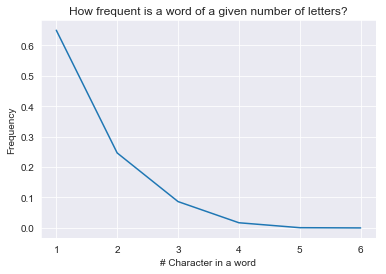

In [12]:
word_stats = (
              search_word_filter[["pattern", "count"]]
              .groupby("pattern")["count"]
              .agg(["sum", "mean", "std"])
              .sort_values("sum", ascending=False)
              .reset_index()
              .rename(columns={"pattern" : "word",
                                "sum" : "n"
                              })
              .assign(freq=lambda df: df["n"]/df["n"].sum(),
                      n_character=lambda df: df["word"].str.len())
              )

freq_char_word = (
                  word_stats[["n_character", "freq"]]
                  .groupby("n_character")["freq"]
                  .agg("sum")
                  .reset_index()
                 )

f4 = sns.lineplot(x="n_character", y="freq", data=freq_char_word, estimator=None)
f4.set(title="How frequent is a word of a given number of letters?",
       xlabel="# Character in a word",
       ylabel="Frequency")
plt.show()


 So in fact we just have 702 differents words found.
 Most of them have few characters <= 3 and are very commons.
 But what about sequences? Which sequence contain more words ?

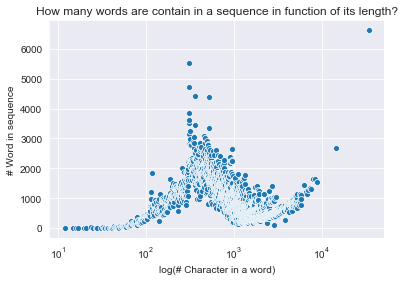

In [13]:
seq_stats = (
              search_word_filter[["string", "count"]]
              .groupby("string")["count"]
              .agg(["sum", "mean", "std"])
              .sort_values("sum", ascending=False)
              .reset_index()
              .rename(columns={"string" : "sequence",
                                "sum" : "n"
                              })
              .assign(freq=lambda df: df["n"]/df["n"].sum(),
                      n_character=lambda df: df["sequence"].str.len())
              )

freq_char_seq = (
                  seq_stats[["n_character", "n"]]
                  .groupby("n_character")["n"]
                  .agg("sum")
                  .reset_index()
                 )

f5 = sns.scatterplot(x="n_character", y="n", data=freq_char_seq)
f5.set_xscale('log')
f5.set(title="How many words are contain in a sequence in function of its length?",
       xlabel="log(# Character in a word)",
       ylabel="# Word in sequence")
plt.show()


 So sequences of few hundred long have more thant 3,000 word!
 I think it could be related to the number of "A" in the sequence